In [119]:
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import pandas as pd
import numpy as np
from glob import glob
#from utils import *
from keras.layers import Dense, Conv2D, BatchNormalization, Convolution2D, Dropout, Flatten, MaxPooling2D, Lambda, ZeroPadding2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches
import cv2

%matplotlib inline
cwd = os.getcwd()
input_dir = os.path.join(cwd ,'for_pt_reg')
#input_dir = os.path.join(os.path.dirname(cwd), 'data', 'for_pt_reg')
TARGET_WIDTH = 300
TARGET_HEIGHT = 300
img_shape=(300, 300, 3)

target_size = (300,300)

In [120]:
tr_data.shape

(189, 300, 300, 3)

In [121]:
val_data.shape

(34, 300, 300, 3)

# Setup

In [25]:
ann = pd.read_csv('subset_pt_data.csv')

In [26]:
input_dir

'/home/ryanryanadmin/Documents/ds/whale_recognition/for_pt_reg'

In [27]:
tr_b = ImageDataGenerator().flow_from_directory(input_dir+'/train',
                                                shuffle=False, 
                                                target_size=target_size, 
                                                batch_size=1,
                                               class_mode=None)

Found 189 images belonging to 1 classes.


In [28]:
val_b = ImageDataGenerator().flow_from_directory(input_dir+'/valid',
                                                shuffle=False, 
                                                target_size=target_size, 
                                                batch_size=1,
                                               class_mode=None)

Found 34 images belonging to 1 classes.


In [29]:
tr_files = tr_b.filenames

In [30]:
val_files = val_b.filenames

In [31]:
tr_data = np.concatenate([tr_b.next() for i in range(tr_b.samples)])

In [32]:
val_data = np.concatenate([val_b.next() for i in range(val_b.samples)])

In [33]:
tr_data.shape

(189, 300, 300, 3)

In [34]:
tr_files= [f[f.find('/')+1:] for f in tr_b.filenames]

In [35]:
val_files = [f[f.find('/')+1:] for f in val_b.filenames]

In [36]:
tr_ann = ann[ann.Image.isin(tr_files)]

In [37]:
val_ann = ann[ann.Image.isin(val_files)]

In [38]:
val_ann.head()

,Image,whaleID,height,width,image_width,image_height,bboxx,bboxy,filename,x_1,y_1,x_2,y_2,x1_new,x2_new,y1_new,y2_new
4,w_354.jpg,whale_34656,487.775239,385.004984,3072,2048,1852.932354,949.474443,w_354.jpg,2133.758724,1268.003988,1911.194417,1086.277168,219.549410,46.124922,196.199374,84.430589
7,w_348.jpg,whale_53079,627.956295,809.733117,3072,2048,1199.254879,698.778433,w_348.jpg,1372.139581,1037.272183,1684.546361,935.178465,64.146906,179.891257,162.083979,113.309700
11,w_199.jpg,whale_11076,535.045676,624.219955,3072,2048,1384.548020,708.700851,w_199.jpg,1474.233300,829.000997,1747.844467,853.503490,43.366108,174.863586,67.845234,81.583777
13,w_69.jpg,whale_95831,522.596560,482.652874,3072,2048,1278.197956,552.554325,w_69.jpg,1441.563310,910.675972,1455.856431,708.530409,101.665184,110.549283,205.900306,89.857313
16,w_214.jpg,whale_24730,519.267920,622.455775,3072,2048,1461.273184,1121.751852,w_214.jpg,1927.529412,1425.228315,1629.415753,1298.632104,224.849426,81.169985,175.763784,102.624539


In [39]:
tr_y = []
for f in tr_files:
    r = tr_ann[tr_ann.Image == f]
    x1 = r.x1_new.values[0]
    y1 = r.y1_new.values[0]
    x2 = r.x2_new.values[0]
    y2 = r.y2_new.values[0]
    tr_y.append([x1,y1,x2,y2])

val_y = []
for f in val_files:
    r = val_ann[val_ann.Image == f]
    x1 = r.x1_new.values[0]
    y1 = r.y1_new.values[0]
    x2 = r.x2_new.values[0]
    y2 = r.y2_new.values[0]
    val_y.append([x1,y1,x2,y2])

tr_y = np.array(tr_y)

val_y = np.array(val_y)

In [81]:
tr_y[:2,:]

array([[  81.3104432 ,  128.87539683,  159.51233737,   34.55395071],
       [ 170.01686525,  162.04056336,   31.44415873,    5.42117879]])

In [45]:
def check_pts(names, pts, sub_dir):
    idx = np.random.randint(0, high=len(names))
    print(idx)
    f = names[idx]
    pt = pts[idx,:]    
    
    f_name =os.path.join(input_dir, sub_dir, 'wrap', f)
    im = cv2.imread(f_name)
    fig, ax = plt.subplots()
    ax.imshow(im)
    ax.scatter(pt[0], pt[1], s=20, c='red', marker='o')
    ax.scatter(pt[2], pt[3], s=20, c='yellow', marker='o')

    #cv2.imwrite(os.path.join(save_dir, r.Image), rot_n)
    
    plt.show()


82


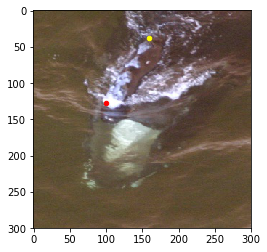

In [64]:
check_pts(tr_files, tr_y, 'train')

33


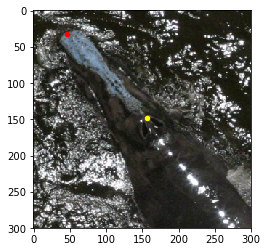

In [80]:
check_pts(val_files, val_y, 'valid')

# Fit Model

In [118]:
tr_data.shape

(189, 300, 300, 3)

In [87]:
np.mean?

In [88]:
tr_mean = np.mean(tr_data, axis=(0,1,2))

In [89]:
tr_mean.shape

(3,)

In [91]:
tr_mean.reshape((3,1,1))

array([[[  98.26221466]],

       [[ 114.43192291]],

       [[ 124.08991241]]], dtype=float32)

In [92]:
tr_mean_r = tr_mean.reshape((3,1,1))

In [126]:
def std(x): 
    x = x-tr_mean
    return x

In [127]:
def get_model():
    return Sequential([
            Lambda(std, input_shape=img_shape),
            ZeroPadding2D((1, 1)),
            Convolution2D(64, 3, 3, activation='relu'),
            ZeroPadding2D((1, 1)),
            Convolution2D(64, 3, 3, activation='relu'),
            MaxPooling2D((2, 2), strides=(2, 2)),
            BatchNormalization(),
            ZeroPadding2D((1, 1)),
            Convolution2D(128, 3, 3, activation='relu'),
            ZeroPadding2D((1, 1)),
            Convolution2D(128, 3, 3, activation='relu'),
            MaxPooling2D((2, 2), strides=(2, 2)),
            BatchNormalization(),
            ZeroPadding2D((1, 1)),
            Convolution2D(256, 3, 3, activation='relu'),
            ZeroPadding2D((1, 1)),
            Convolution2D(256, 3, 3, activation='relu'),
            MaxPooling2D((2, 2), strides=(2, 2)),
            BatchNormalization(),
            ZeroPadding2D((1, 1)),
            Convolution2D(512, 3, 3, activation='relu'),
            MaxPooling2D((2, 2), strides=(2, 2)),
            BatchNormalization(),
            Flatten(),
            Dense(1024, activation='relu'),
            Dense(512, activation='relu'),
            Dense(4)
        ])

In [128]:
model = get_model()

/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu")`
/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:19: 

In [129]:
model.compile(Adam(lr=0.001), loss='mean_squared_error', metrics=['accuracy'])

In [130]:
model.fit(tr_data, tr_y, validation_data=(val_data, val_y), shuffle=True, nb_epoch=2)

/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/keras/models.py:834: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 189 samples, validate on 34 samples
Epoch 1/2
 32/189 [====>.........................] - ETA: 603s - loss: 19359.9355 - acc: 0.1875

KeyboardInterrupt: 

In [59]:
model.save_weights('bb_reg_3.13.h5')

In [57]:
model.save_weights('whale_bb_129.h5')

In [56]:
model.fit(tr_data, tr_y, validation_data=(val_data, val_y), shuffle=True, nb_epoch=10)

Train on 4089 samples, validate on 455 samples
Epoch 1/10
4089/4089 [==============================] - 450s - loss: 106.7081 - acc: 0.8638 - val_loss: 131.0938 - val_acc: 0.8308
Epoch 2/10
4089/4089 [==============================] - 450s - loss: 105.2361 - acc: 0.8655 - val_loss: 124.7798 - val_acc: 0.8242
Epoch 3/10
4089/4089 [==============================] - 450s - loss: 92.5360 - acc: 0.8802 - val_loss: 185.1914 - val_acc: 0.8066
Epoch 4/10
4089/4089 [==============================] - 450s - loss: 86.2257 - acc: 0.8792 - val_loss: 148.2277 - val_acc: 0.8264
Epoch 5/10
4089/4089 [==============================] - 450s - loss: 80.8730 - acc: 0.8826 - val_loss: 129.3283 - val_acc: 0.8286
Epoch 6/10
 768/4089 [====>.........................] - ETA: 354s - loss: 71.0460 - acc: 0.8802

KeyboardInterrupt: 

In [59]:
model.save_weights('whale_bb_122.h5')

In [60]:
model.optimizer.lr = 0.0001

In [61]:
model.fit(tr_data, tr_y, validation_data=(val_data, val_y), shuffle=True, nb_epoch=10)

Train on 4089 samples, validate on 455 samples
Epoch 1/10
4089/4089 [==============================] - 450s - loss: 39.2634 - acc: 0.9171 - val_loss: 138.6453 - val_acc: 0.8286
Epoch 2/10
4089/4089 [==============================] - 449s - loss: 38.2008 - acc: 0.9156 - val_loss: 131.2853 - val_acc: 0.8418
Epoch 3/10
4089/4089 [==============================] - 449s - loss: 39.7533 - acc: 0.9235 - val_loss: 130.9264 - val_acc: 0.8374
Epoch 4/10
4089/4089 [==============================] - 451s - loss: 32.5617 - acc: 0.9254 - val_loss: 121.4119 - val_acc: 0.8396
Epoch 5/10
4089/4089 [==============================] - 451s - loss: 31.3996 - acc: 0.9269 - val_loss: 124.0389 - val_acc: 0.8352
Epoch 6/10
4089/4089 [==============================] - 450s - loss: 27.6569 - acc: 0.9337 - val_loss: 129.1431 - val_acc: 0.8571
Epoch 7/10
4089/4089 [==============================] - 450s - loss: 25.9184 - acc: 0.9354 - val_loss: 134.1947 - val_acc: 0.8022
Epoch 8/10
4089/4089 [=====================

In [62]:
model.optimizer.lr = 0.00001

In [63]:
model.fit(tr_data, tr_y, validation_data=(val_data, val_y), shuffle=True, nb_epoch=10)

Train on 4089 samples, validate on 455 samples
Epoch 1/10
4089/4089 [==============================] - 450s - loss: 18.9432 - acc: 0.9445 - val_loss: 131.1113 - val_acc: 0.8440
Epoch 2/10
4089/4089 [==============================] - 450s - loss: 21.7494 - acc: 0.9401 - val_loss: 121.7423 - val_acc: 0.8418
Epoch 3/10
4089/4089 [==============================] - 449s - loss: 17.3245 - acc: 0.9469 - val_loss: 127.7389 - val_acc: 0.8484
Epoch 4/10
4089/4089 [==============================] - 450s - loss: 15.2120 - acc: 0.9411 - val_loss: 113.5965 - val_acc: 0.8484
Epoch 5/10
4089/4089 [==============================] - 450s - loss: 17.6442 - acc: 0.9411 - val_loss: 122.0209 - val_acc: 0.8374
Epoch 6/10
4089/4089 [==============================] - 451s - loss: 16.8782 - acc: 0.9533 - val_loss: 119.5340 - val_acc: 0.8330
Epoch 7/10
4089/4089 [==============================] - 450s - loss: 15.4750 - acc: 0.9467 - val_loss: 124.3540 - val_acc: 0.8396
Epoch 8/10
4089/4089 [=====================

KeyboardInterrupt: 

In [65]:
model.optimizer.lr = 0.000001

In [66]:
model.fit(tr_data, tr_y, validation_data=(val_data, val_y), shuffle=True, nb_epoch=1)

Train on 4089 samples, validate on 455 samples
Epoch 1/1
4089/4089 [==============================] - 450s - loss: 13.0874 - acc: 0.9552 - val_loss: 116.9361 - val_acc: 0.8374


In [67]:
model.save_weights('116.9.h5')

In [68]:
model.fit(tr_data, tr_y, validation_data=(val_data, val_y), shuffle=True, nb_epoch=1)

Train on 4089 samples, validate on 455 samples
Epoch 1/1
4089/4089 [==============================] - 450s - loss: 13.6130 - acc: 0.9579 - val_loss: 131.2703 - val_acc: 0.8220


In [69]:
model.load_weights('116.9.h5')

In [70]:
preds = model.predict(val_data)

50
w_5616.jpg


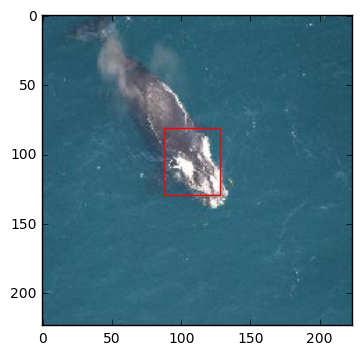

In [90]:
check_smaller(val_files, preds)

# Step forward. Get predictions on test set.

In [91]:
test_b = ImageDataGenerator().flow_from_directory(img_dir+'/test',
                                                shuffle=False, 
                                                target_size=target_size, 
                                                batch_size=1,
                                               class_mode=None)

Found 6925 images belonging to 1 classes.


In [92]:
test_files = test_b.filenames

In [93]:
save_array('test_file_names.bc', test_files)

In [94]:
test_data = np.concatenate([test_b.next() for i in range(test_b.nb_sample)])

In [95]:
save_array('test_data_224_224.bc', test_data)

In [96]:
test_preds = model.predict(test_data)

In [99]:
test_files = [f[f.find('/')+1:] for f in test_files]

821
w_2771.jpg


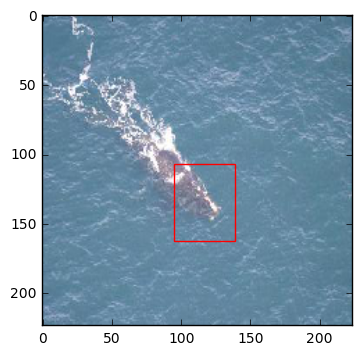

In [124]:
check_smaller(test_files, test_preds)

In [125]:
test_ann = pd.DataFrame(np.hstack((np.array(test_files)[:, np.newaxis], test_preds)), columns=['Image', 'width', 'height', 'x', 'y'])

In [126]:
test_ann.head()

,Image,width,height,x,y
0,w_8037.jpg,29.0913066864,50.4047203064,90.4007720947,98.9544677734
1,w_4494.jpg,32.1990737915,45.0582427979,84.8776702881,57.4592323303
2,w_4673.jpg,44.787689209,54.903339386,103.601135254,91.891708374
3,w_8273.jpg,41.8063430786,50.1853218079,100.628494263,60.9373054504
4,w_7611.jpg,37.7578010559,57.7667121887,120.307563782,76.0566101074


In [128]:
test_ann.to_csv('test_ann.csv', index=False)